<a href="https://colab.research.google.com/drive/1_JG9m3uzCvYZI3D8tzP6mLQp4Vhs8EKs?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Image Classification</b><br>
--
AUTHOR :
* Juna
* Qiya S.

The dataset contains images from the gastrointestinal tract.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!wget https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip

--2021-01-07 00:50:08--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  13.2MB/s    in 2m 5s   

2021-01-07 00:52:13 (19.0 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



In [ ]:
import os

def create_folder_unless_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_folder_unless_exists('data/raw')
create_folder_unless_exists('data/zip')
create_folder_unless_exists('models')
create_folder_unless_exists('results/cnn_simple')
create_folder_unless_exists('results/cnn_resnet_tl')
create_folder_unless_exists('results/cnn_resnet_tl_tuned')

In [ ]:
!unzip -qq kvasir-dataset-v2.zip
!cp kvasir-dataset-v2/* data/raw -r
!cp kvasir-dataset-v2.zip data/zip -r
!rm kvasir-dataset-v2 -rf
!rm kvasir-dataset-v2.zip

A
A


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save_path=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.rcParams.update({'font.size': 18})


    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=18, ha="right")
        plt.yticks(tick_marks, target_names, fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.autoscale()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

def display_confusion_matrix(y_pred, y_true, target_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, target_names, normalize=False, save_path=save_path)

    if RunningInCOLAB and save_path:
        files.download(save_path)
        
def display_classification_report(y_pred, y_true, target_names, save_path=None):
    cr = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    
    df = pd.DataFrame(cr).transpose()
    df = df.round(2)

    print(df)
    
    if save_path:
        df.to_csv(save_path, sep=';')
    
    if RunningInCOLAB and save_path:
        files.download(save_path)

def plot_history(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='right')
    plt.show()
    
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='right')
    plt.show()

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

def split_image_dataset(raw_path, processed_path, split_ratio):
    shutil.copytree(raw_path, processed_path)
    
    train_path = os.path.join(processed_path, 'train')
    test_path = os.path.join(processed_path,'test')
    
    _, dirs, _ = next(os.walk(processed_path))
    
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(processed_path, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - split_ratio))

    print(f"Total data per class: {data_counter_per_class}")
    print(f"Test instances per class: {test_counter}")
    
    for i in range(len(dirs)):
        files = get_files_from_folder(os.path.join(processed_path, dirs[i]))
        train_path = os.path.join(processed_path, 'train' ,dirs[i])
        test_path = os.path.join(processed_path, 'test' ,dirs[i])

        if not os.path.exists(train_path):
            os.makedirs(train_path)
        if not os.path.exists(test_path):
            os.makedirs(test_path)
            
        for j in range(int(data_counter_per_class[i])):
            src = os.path.join(processed_path, dirs[i], files[j])
            if j < test_counter[i]:
                dst = os.path.join(processed_path, 'test', dirs[i], files[j])
            else:
                dst = os.path.join(processed_path, 'train', dirs[i], files[j])
            shutil.move(src, dst)

        os.removedirs(os.path.join(processed_path, dirs[i]))

In [ ]:
split_image_dataset('data/raw', 'data/processed', split_ratio=0.80)

Total data per class: [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
Test instances per class: [200. 200. 200. 200. 200. 200. 200. 200.]


In [ ]:
train_path = 'data/processed/train'
test_path = 'data/processed/test'
batch_size = 32

target_w = 256
target_h = 256
target_size = (target_w, target_h) 
target_dims = 3

In [ ]:
cnn_train_idg = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) 

cnn_train_datagen = cnn_train_idg.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    subset='training') 

cnn_val_datagen = cnn_train_idg.flow_from_directory(
    train_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    subset='validation') 

cnn_test_idg = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

cnn_test_datagen = cnn_test_idg.flow_from_directory(
    test_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False)

Found 5120 images belonging to 8 classes.
Found 1280 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


In [ ]:
def build_simple_cnn():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_w, target_h, target_dims)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu')
    ])

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(8, activation='softmax'))

    model.summary()

    return model

In [ ]:
simple_cnn = build_simple_cnn()

simple_cnn.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [ ]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import files

In [ ]:
cnn_history = simple_cnn.fit(cnn_train_datagen, 
                        epochs=6,
                        verbose=1, 
                        validation_data=cnn_val_datagen)

simple_cnn.save('models/cnn_simple.hdf5')

Epoch 1/6
160/160 [==============================] - 167s 1s/step - loss: 0.8080 - accuracy: 0.6338 - val_loss: 0.7737 - val_accuracy: 0.6687
Epoch 2/6
160/160 [==============================] - 166s 1s/step - loss: 0.7415 - accuracy: 0.6687 - val_loss: 0.7106 - val_accuracy: 0.6703
Epoch 3/6
160/160 [==============================] - 166s 1s/step - loss: 0.6831 - accuracy: 0.6949 - val_loss: 0.7597 - val_accuracy: 0.6578
Epoch 4/6
160/160 [==============================] - 166s 1s/step - loss: 0.6749 - accuracy: 0.6854 - val_loss: 0.7266 - val_accuracy: 0.6883
Epoch 5/6
160/160 [==============================] - 171s 1s/step - loss: 0.6498 - accuracy: 0.7074 - val_loss: 0.7081 - val_accuracy: 0.6875
Epoch 6/6
160/160 [==============================] - 172s 1s/step - loss: 0.6408 - accuracy: 0.7121 - val_loss: 0.6945 - val_accuracy: 0.7102


In [ ]:
cnn_predictions = simple_cnn.predict(cnn_test_datagen, verbose=1)

50/50 [==============================] - 26s 529ms/step


In [ ]:
cnn_predictions

array([[3.2985091e-01, 6.7003793e-01, 1.8504447e-06, ..., 4.1451671e-07,
        1.2026545e-06, 1.0726725e-04],
       [2.5532416e-01, 3.6439842e-01, 1.6559850e-04, ..., 5.1201655e-06,
        1.3368416e-01, 2.4569546e-01],
       [3.4321064e-01, 6.5676135e-01, 2.9340541e-09, ..., 1.7428547e-09,
        9.6849604e-09, 2.7993765e-05],
       ...,
       [1.6397749e-09, 1.8782236e-08, 4.9714527e-10, ..., 1.9635196e-09,
        2.8669869e-05, 9.9936646e-01],
       [1.9608107e-10, 4.6651887e-09, 2.5302149e-09, ..., 1.7742490e-09,
        1.0635555e-05, 9.9987638e-01],
       [2.6817941e-09, 5.4188430e-08, 2.5853753e-05, ..., 4.1302105e-06,
        4.3073094e-05, 9.9938059e-01]], dtype=float32)

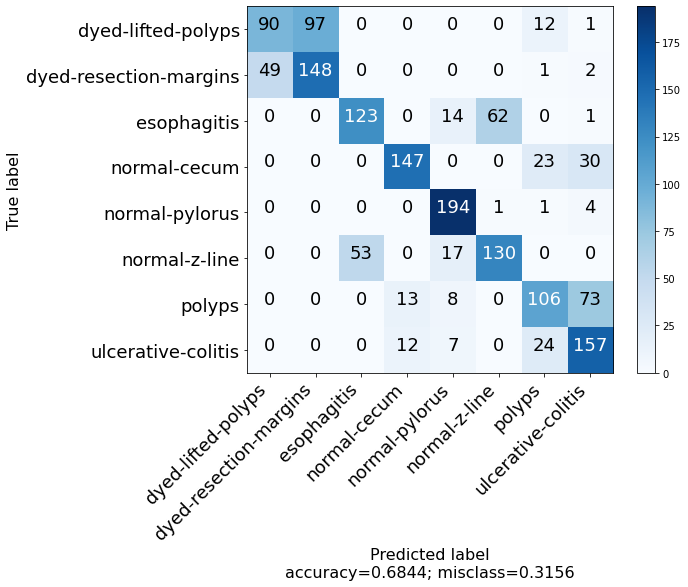

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        precision  recall  f1-score  support
dyed-lifted-polyps           0.65    0.45      0.53   200.00
dyed-resection-margins       0.60    0.74      0.67   200.00
esophagitis                  0.70    0.62      0.65   200.00
normal-cecum                 0.85    0.74      0.79   200.00
normal-pylorus               0.81    0.97      0.88   200.00
normal-z-line                0.67    0.65      0.66   200.00
polyps                       0.63    0.53      0.58   200.00
ulcerative-colitis           0.59    0.78      0.67   200.00
accuracy                     0.68    0.68      0.68     0.68
macro avg                    0.69    0.68      0.68  1600.00
weighted avg                 0.69    0.68      0.68  1600.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluate the model 
unique_labels = list(cnn_test_datagen.class_indices.keys())

y_pred = np.argmax(cnn_predictions, axis=-1)
y_true = cnn_test_datagen.classes[cnn_test_datagen.index_array]

display_confusion_matrix(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_simple/cnn_simple_confusion_matrix.png'
)

display_classification_report(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_simple/cnn_simple_classification_report.csv'
)

In [ ]:
rn_train_idg = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) 

rn_train_datagen = rn_train_idg.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    subset='training') 

rn_val_datagen = rn_train_idg.flow_from_directory(
    train_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    subset='validation') 

rn_test_idg = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)

rn_test_datagen = rn_test_idg.flow_from_directory(
    test_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False)

Found 5120 images belonging to 8 classes.
Found 1280 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


In [ ]:
# Now we will use the transfer learning!
def build_transfer_learning_model():
  base_model = keras.applications.resnet.ResNet50(include_top=False, 
                                                  weights='imagenet', 
                                                  input_shape=(target_w, target_h, target_dims))
  for layer in base_model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
  model = keras.models.Sequential([
                       base_model,
                       keras.layers.GlobalAveragePooling2D(),
                       keras.layers.Dropout(0.5),
                       keras.layers.Dense(8, activation="softmax")
  ])
  
  model.summary()

  return model

In [ ]:
rn_model = build_transfer_learning_model()

rn_model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ]
)

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 16392     
Total params: 23,604,104
Trainable params: 69,512
Non-trainable params: 23,534,592
_________________________________________________________________


In [31]:
rn_history = rn_model.fit(rn_train_datagen, 
                        epochs=15,
                        verbose=1, 
                        validation_data=rn_val_datagen)

rn_model.save('models/cnn_resnet_tl.hdf5')

Epoch 1/15
160/160 [==============================] - 195s 1s/step - loss: 1.2365 - accuracy: 0.5393 - val_loss: 0.7948 - val_accuracy: 0.7539
Epoch 2/15
160/160 [==============================] - 193s 1s/step - loss: 0.9166 - accuracy: 0.6529 - val_loss: 0.6448 - val_accuracy: 0.7883
Epoch 3/15
160/160 [==============================] - 192s 1s/step - loss: 0.7729 - accuracy: 0.7109 - val_loss: 0.5683 - val_accuracy: 0.8008
Epoch 4/15
160/160 [==============================] - 191s 1s/step - loss: 0.6779 - accuracy: 0.7414 - val_loss: 0.4959 - val_accuracy: 0.8234
Epoch 5/15
160/160 [==============================] - 191s 1s/step - loss: 0.6093 - accuracy: 0.7650 - val_loss: 0.4611 - val_accuracy: 0.8234
Epoch 6/15
160/160 [==============================] - 193s 1s/step - loss: 0.5507 - accuracy: 0.7936 - val_loss: 0.4491 - val_accuracy: 0.8242
Epoch 7/15
160/160 [==============================] - 193s 1s/step - loss: 0.5220 - accuracy: 0.7955 - val_loss: 0.4265 - val_accuracy: 0.8344

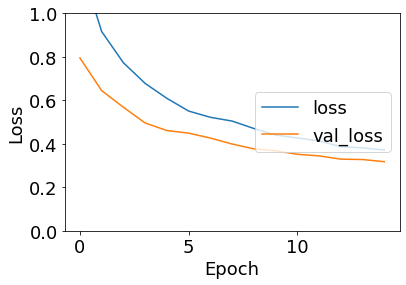

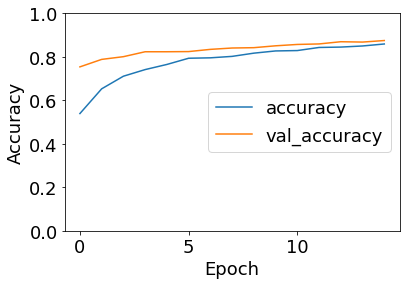

In [32]:
plot_history(rn_history)

In [33]:
rn_predictions = rn_model.predict(rn_test_datagen, verbose=1)

50/50 [==============================] - 29s 573ms/step


In [34]:
rn_predictions

array([[8.9091688e-01, 1.0852815e-01, 3.6434273e-04, ..., 6.6401502e-05,
        1.0878619e-04, 6.7945216e-06],
       [9.5664340e-01, 3.6874309e-02, 2.5599735e-04, ..., 2.5115366e-04,
        4.5485301e-03, 1.4834269e-04],
       [9.5973754e-01, 4.0252890e-02, 3.0684162e-06, ..., 2.0683622e-06,
        1.8332373e-07, 3.5017292e-06],
       ...,
       [1.5950209e-06, 1.5895330e-06, 8.9746918e-06, ..., 7.5790872e-06,
        5.1095990e-06, 9.9997282e-01],
       [6.9255698e-06, 2.9142543e-06, 2.6467189e-04, ..., 4.6406017e-06,
        4.6720011e-06, 9.9971467e-01],
       [4.1493411e-05, 7.0101855e-04, 1.3404448e-02, ..., 4.7949891e-04,
        2.8695140e-05, 9.8533940e-01]], dtype=float32)

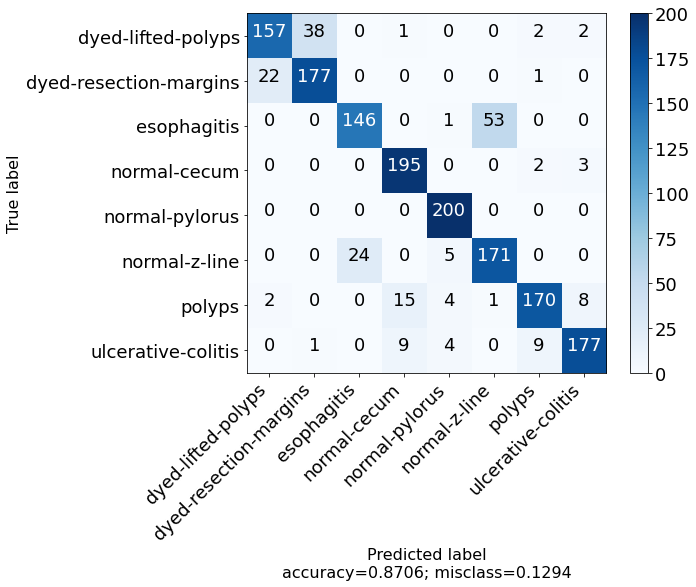

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        precision  recall  f1-score  support
dyed-lifted-polyps           0.87    0.78      0.82   200.00
dyed-resection-margins       0.82    0.88      0.85   200.00
esophagitis                  0.86    0.73      0.79   200.00
normal-cecum                 0.89    0.98      0.93   200.00
normal-pylorus               0.93    1.00      0.97   200.00
normal-z-line                0.76    0.86      0.80   200.00
polyps                       0.92    0.85      0.89   200.00
ulcerative-colitis           0.93    0.88      0.91   200.00
accuracy                     0.87    0.87      0.87     0.87
macro avg                    0.87    0.87      0.87  1600.00
weighted avg                 0.87    0.87      0.87  1600.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
unique_labels = list(rn_test_datagen.class_indices.keys())

y_pred = np.argmax(rn_predictions, axis=-1)
y_true = rn_test_datagen.classes[rn_test_datagen.index_array]

display_confusion_matrix(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_resnet_tl/cnn_resnet_tl_confusion_matrix.png'
)

display_classification_report(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_resnet_tl/cnn_resnet_tl_classification_report.csv'
)

In [38]:
rn_model.trainable = True

In [40]:
rn_model.compile(
    optimizer=keras.optimizers.Adam(0.000001),  
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ],
)

rn_history_ft = rn_model.fit(rn_train_datagen, 
                        epochs=60,
                        verbose=1, 
                        validation_data=rn_val_datagen)

rn_model.save('models/cnn_resnet_tl_tuned.hdf5')

Epoch 1/60
160/160 [==============================] - 205s 1s/step - loss: 0.3393 - accuracy: 0.8649 - val_loss: 0.3094 - val_accuracy: 0.8859
Epoch 2/60
160/160 [==============================] - 199s 1s/step - loss: 0.3280 - accuracy: 0.8687 - val_loss: 0.3031 - val_accuracy: 0.8750
Epoch 3/60
160/160 [==============================] - 197s 1s/step - loss: 0.3231 - accuracy: 0.8686 - val_loss: 0.2940 - val_accuracy: 0.8773
Epoch 4/60
160/160 [==============================] - 200s 1s/step - loss: 0.3250 - accuracy: 0.8733 - val_loss: 0.2939 - val_accuracy: 0.8867
Epoch 5/60
160/160 [==============================] - 198s 1s/step - loss: 0.3182 - accuracy: 0.8830 - val_loss: 0.3006 - val_accuracy: 0.8828
Epoch 6/60
160/160 [==============================] - 195s 1s/step - loss: 0.2839 - accuracy: 0.8840 - val_loss: 0.2851 - val_accuracy: 0.8883
Epoch 7/60
160/160 [==============================] - 194s 1s/step - loss: 0.2981 - accuracy: 0.8857 - val_loss: 0.2786 - val_accuracy: 0.8883

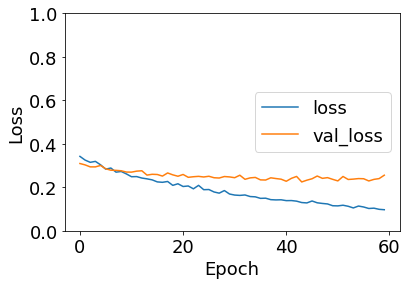

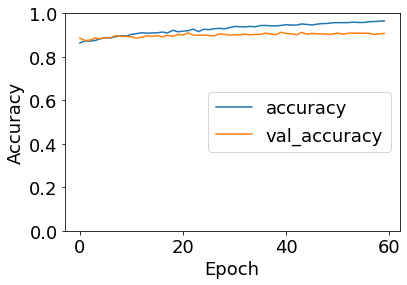

In [41]:
plot_history(rn_history_ft)

In [42]:
rn_predictions = rn_model.predict(rn_test_datagen, verbose=1)

50/50 [==============================] - 27s 533ms/step


In [43]:
rn_predictions

array([[9.9956185e-01, 4.2956907e-04, 2.8769248e-06, ..., 7.0903536e-07,
        4.8353836e-06, 4.2089056e-08],
       [9.9966657e-01, 2.8625698e-04, 2.1358944e-06, ..., 2.2348104e-06,
        3.7261907e-05, 5.4563952e-07],
       [9.9998724e-01, 1.2702574e-05, 3.0364498e-09, ..., 3.8177541e-09,
        1.2265926e-10, 5.6559996e-10],
       ...,
       [5.9892379e-08, 1.2443515e-07, 7.7576641e-07, ..., 7.3735413e-07,
        3.3282828e-07, 9.9999785e-01],
       [1.1239873e-07, 3.3947966e-08, 2.0497999e-05, ..., 9.6246872e-08,
        3.2275440e-07, 9.9997890e-01],
       [1.0895113e-06, 2.3816630e-05, 1.7947279e-03, ..., 1.2153318e-05,
        2.0961004e-06, 9.9816579e-01]], dtype=float32)

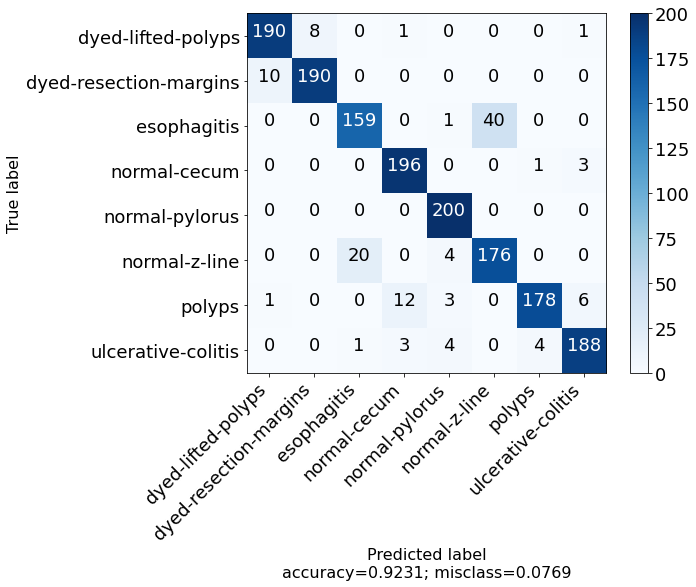

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        precision  recall  f1-score  support
dyed-lifted-polyps           0.95    0.95      0.95   200.00
dyed-resection-margins       0.96    0.95      0.95   200.00
esophagitis                  0.88    0.80      0.84   200.00
normal-cecum                 0.92    0.98      0.95   200.00
normal-pylorus               0.94    1.00      0.97   200.00
normal-z-line                0.81    0.88      0.85   200.00
polyps                       0.97    0.89      0.93   200.00
ulcerative-colitis           0.95    0.94      0.94   200.00
accuracy                     0.92    0.92      0.92     0.92
macro avg                    0.92    0.92      0.92  1600.00
weighted avg                 0.92    0.92      0.92  1600.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
unique_labels = list(rn_test_datagen.class_indices.keys())

y_pred = np.argmax(rn_predictions, axis=-1)
y_true = rn_test_datagen.classes[rn_test_datagen.index_array]

display_confusion_matrix(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_resnet_tl_tuned/cnn_resnet_tl_tuned_confusion_matrix.png'
)

display_classification_report(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='results/cnn_resnet_tl_tuned/cnn_resnet_tl_tuned_classification_report.csv'
)